In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import some necessary librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

# This module provides an interface to the optional garbage collector.
# It provides the ability to disable the collector, tune the collection frequency, and set debugging options.
import gc

import datetime
import time

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

# Settings
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (12, 4)
pd.options.display.max_columns = 500

In [ ]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
import os
print(os.listdir("datasets"))

In [ ]:
%%time
train_org = reduce_mem_usage(pd.read_csv("datasets/train.csv", parse_dates=["first_active_month"]))
print('Train dataset dimension: ', train_org.shape)

In [ ]:
%%time
test_org = reduce_mem_usage(pd.read_csv("datasets/test.csv", parse_dates=["first_active_month"]))
print('Test dataset dimension: ', test_org.shape)

In [ ]:
%%time
hist_trans_org = reduce_mem_usage(pd.read_csv("datasets/historical_transactions.csv", parse_dates=["purchase_date"]))
print('Historical Transactions dataset dimension: ', hist_trans_org.shape)

In [ ]:
%%time
merchants_org = reduce_mem_usage(pd.read_csv("datasets/merchants.csv"))
print('New Merchant dataset dimension: ', merchants_org.shape)

In [ ]:
%%time
new_merch_trans_org = reduce_mem_usage(pd.read_csv("datasets/new_merchant_transactions.csv", parse_dates=["purchase_date"]))
print('New Merchant dataset dimension: ', new_merch_trans_org.shape)

In [ ]:
print('First few observations of Train Dataset:')
train_org.head()

In [ ]:
print('First few observations of Test Dataset:')
test_org.head()

In [ ]:
print('First few observations of Historical Transactions Dataset:')
hist_trans_org.head()

In [ ]:
print('First few observations of Merchants Dataset:')
merchants_org.head()

In [ ]:
print('First few observations of New Merchant Transactions Dataset:')
new_merch_trans_org.head()

In [ ]:
# histogram of target label
f, ax = plt.subplots(figsize=(14, 6))
sns.distplot(train_org['target']);

In [ ]:
train_org.describe()

In [ ]:
null_feat_df = pd.DataFrame()
null_feat_df['Null Count'] = train_org.isnull().sum().sort_values(ascending=False)
null_feat_df['Null Pct'] = null_feat_df['Null Count'] / float(len(train_org))

null_feat_df = null_feat_df[null_feat_df['Null Pct'] > 0]

total_null_feats = null_feat_df.shape[0]
null_feat_names = null_feat_df.index
print('Total number of features having null values in train dataset: ', total_null_feats)
print('Name of features having null values in train dataset: ', null_feat_names)
del null_feat_df

In [ ]:
null_feat_df = pd.DataFrame()
null_feat_df['Null Count'] = test_org.isnull().sum().sort_values(ascending=False)
null_feat_df['Null Pct'] = null_feat_df['Null Count'] / float(len(test_org))

null_feat_df = null_feat_df[null_feat_df['Null Pct'] > 0]

total_null_feats = null_feat_df.shape[0]
null_feat_names = null_feat_df.index
print('Total number of features having null values in test dataset: ', total_null_feats)
print('Name of features having null values in test dataset: ', null_feat_names)
del null_feat_df

In [ ]:
%%time
train_df_proc = train_org.copy()
test_df_proc = test_org.copy()

# Handle missing value of first_active_month in test dataset
top_active_month = test_org['first_active_month'].describe()['top']
test_df_proc['first_active_month'] = test_df_proc['first_active_month'].fillna(top_active_month)

for df in [train_df_proc, test_df_proc]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elo_year'] = df['first_active_month'].dt.year
    df['elo_month'] = df['first_active_month'].dt.month
    #df['elo_week'] = df["first_active_month"].dt.weekofyear
    #df['elo_dayofweek'] = df['first_active_month'].dt.dayofweek
    df['elo_elapsed_days'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days

In [ ]:
null_feat_df = pd.DataFrame()
null_feat_df['Null Count'] = hist_trans_org.isnull().sum().sort_values(ascending=False)
null_feat_df['Null Pct'] = null_feat_df['Null Count'] / float(len(hist_trans_org))

null_feat_df = null_feat_df[null_feat_df['Null Pct'] > 0]

total_null_feats = null_feat_df.shape[0]
null_feat_names = null_feat_df.index
print('Total number of features having null values: ', total_null_feats)
print('Name of features having null values: ', null_feat_names)
print(null_feat_df)

del null_feat_df

In [ ]:
print('History Trans - Unique Values - authorized_flag: ', hist_trans_org['authorized_flag'].unique().tolist())
print('History Trans - Unique Values - category_1: ', hist_trans_org['category_1'].unique().tolist())
print('History Trans - Unique Values - category_2: ', hist_trans_org['category_2'].unique().tolist())
print('History Trans - Unique Values - category_3: ', hist_trans_org['category_3'].unique().tolist())

In [ ]:
hist_trans_org.describe()

In [ ]:
null_feat_df = pd.DataFrame()
null_feat_df['Null Count'] = new_merch_trans_org.isnull().sum().sort_values(ascending=False)
null_feat_df['Null Pct'] = null_feat_df['Null Count'] / float(len(new_merch_trans_org))

null_feat_df = null_feat_df[null_feat_df['Null Pct'] > 0]

total_null_feats = null_feat_df.shape[0]
null_feat_names = null_feat_df.index
print('Total number of features having null values: ', total_null_feats)
print('Name of features having null values: ', null_feat_names)
print(null_feat_df)

del null_feat_df

In [ ]:
print('New Merchant Trans - Unique Values - authorized_flag: ', new_merch_trans_org['authorized_flag'].unique().tolist())
print('New Merchant Trans - Unique Values - category_1     : ', new_merch_trans_org['category_1'].unique().tolist())
print('New Merchant Trans - Unique Values - category_2     : ', new_merch_trans_org['category_2'].unique().tolist())
print('New Merchant Trans - Unique Values - category_3     : ', new_merch_trans_org['category_3'].unique().tolist())

In [ ]:
new_merch_trans_org.describe()

In [ ]:
%%time
hist_trans_df = hist_trans_org.copy()
merch_trans_df = new_merch_trans_org.copy()

print('Historical Transactions dataset dimension: ', hist_trans_df.shape)
hist_trans_df['category_2'] = hist_trans_df['category_2'].fillna(99.0)
hist_trans_df['category_3'] = hist_trans_df['category_3'].fillna('N')
hist_trans_df.loc[hist_trans_df['installments'] == 999, 'installments'] = -1
hist_trans_df.dropna(inplace=True)
print('Historical Transactions dataset dimension after treating null values: ', hist_trans_df.shape)

print('Merchant Transactions dataset dimension: ', merch_trans_df.shape)
merch_trans_df['category_2'] = merch_trans_df['category_2'].fillna(99.0)
merch_trans_df['category_3'] = merch_trans_df['category_3'].fillna('N')
merch_trans_df.loc[merch_trans_df['installments'] == 999, 'installments'] = -1
merch_trans_df.dropna(inplace=True)
print('Merchant Transactions dataset dimension after treating null values: ', merch_trans_df.shape)

gc.collect()

In [ ]:
#hist_trans_df.describe()

In [ ]:
#merch_trans_df.describe()

### Historical Transactions
#### category_1
- when category_1 = 'N' then multiple state_id including -1
- when category_1 = 'Y' then state_id = -1 which might be no states

#### category_2
- when category_2 = 1.0 then state_id  = 9, 12, 15, 16
- when category_2 = 2.0 then state_id  = 6, 10, 18, 23, 24
- when category_2 = 3.0 then state_id  = 1, 2, 3, 7, 8, 11, 17, 19
- when category_2 = 4.0 then state_id  = 4, 13, 14, 22
- when category_2 = 5.0 then state_id  = 5, 20, 21
- when category_2 = 99.0 which was actually null then state_id  = -1 which might be no states

#### category_3
- multiple state_id for category 'A', 'B' & 'C'
- category_3 was null which was imputed to value 'N', might be related to null / remaining category

#### authorized_flag
- for both values 'Y' & 'N', diverse sets of state_id are mapped

In [ ]:
#hist_trans_df.groupby(['category_1','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)
#hist_trans_df.groupby(['category_2','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)
#hist_trans_df.groupby(['category_3','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)
#hist_trans_df.groupby(['authorized_flag','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)

### New Merchant Transactions
#### category_1
- when category_1 = 'N' then multiple state_id including -1
- when category_1 = 'Y' then state_id = -1 which might be no states

#### category_2
- when category_2 = 1.0 then state_id  = 9, 12, 15, 16
- when category_2 = 2.0 then state_id  = 6, 10, 18, 23, 24
- when category_2 = 3.0 then state_id  = 1, 2, 3, 7, 8, 11, 17, 19
- when category_2 = 4.0 then state_id  = 4, 13, 14, 22
- when category_2 = 5.0 then state_id  = 5, 20, 21
- when category_2 = 99.0 which was actually null then state_id  = -1 which might be no states

#### category_3
- multiple state_id for category 'A', 'B' & 'C'
- category_3 was null which was imputed to value 'N', might be related to null / remaining category

#### authorized_flag
- single value 'Y' with diverse sets of state_id are mapped

In [ ]:
#merch_trans_df.groupby(['category_1','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)
#merch_trans_df.groupby(['category_2','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)
#merch_trans_df.groupby(['category_3','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)
#merch_trans_df.groupby(['authorized_flag','state_id'], as_index=False).agg({'card_id': ['count']}, as_index=False)

In [ ]:
print('First few observations of Merchants Dataset:')
merchants_org.head()

In [ ]:
merchants_org.describe()

In [ ]:
null_feat_df = pd.DataFrame()
null_feat_df['Null Count'] = merchants_org.isnull().sum().sort_values(ascending=False)
null_feat_df['Null Pct'] = null_feat_df['Null Count'] / float(len(merchants_org))

null_feat_df = null_feat_df[null_feat_df['Null Pct'] > 0]

total_null_feats = null_feat_df.shape[0]
null_feat_names = null_feat_df.index
print('Total number of features having null values: ', total_null_feats)
print('Name of features having null values: ', null_feat_names)
print(null_feat_df)

del null_feat_df

In [ ]:
print('Merchants - Unique Values - category_1: ', merchants_org['category_1'].unique().tolist())
print('Merchants - Unique Values - category_2: ', merchants_org['category_2'].unique().tolist())
print('Merchants - Unique Values - category_4: ', merchants_org['category_4'].unique().tolist())
print('Merchants - Unique Values - most_recent_sales_range: ', merchants_org['most_recent_sales_range'].unique().tolist())
print('Merchants - Unique Values - most_recent_purchases_range: ', merchants_org['most_recent_purchases_range'].unique().tolist())

In [ ]:
%%time
merchants_df = merchants_org.copy()
print('Merchants dataset dimension: ', merchants_df.shape)

merchants_df['category_2'] = merchants_df['category_2'].fillna(99.0)
range_map = {'A':50, 'B':40, 'C':30, 'D':20, 'E':10}
merchants_df['most_recent_sales_range'] = merchants_df['most_recent_sales_range'].map(range_map)
merchants_df['most_recent_purchases_range'] = merchants_df['most_recent_purchases_range'].map(range_map)
merchants_df.dropna(inplace=True)
print('Merchants dataset dimension after treating null values: ', merchants_df.shape)

merchants_df_dup = merchants_df[merchants_df['merchant_id'].duplicated(keep='first')]
print('Merchants dataset duplicates: ', merchants_df_dup.shape)

#merchants_df.drop_duplicates(subset='merchant_id', keep='first', inplace=True) 
#print('Merchants dataset dimension after treating null values: ', merchants_df.shape)

del merchants_df_dup

In [ ]:
#merchants_df.describe()

### Merchants
#### category_1
- when category_1 = 'N' then multiple state_id including -1
- when category_1 = 'Y' then state_id = -1 which might be no states

#### category_2
- when category_2 = 1.0 then state_id  = 9, 12, 15, 16
- when category_2 = 2.0 then state_id  = 6, 10, 18, 23, 24
- when category_2 = 3.0 then state_id  = 1, 2, 3, 7, 8, 11, 17, 19
- when category_2 = 4.0 then state_id  = 4, 13, 14, 22
- when category_2 = 5.0 then state_id  = 5, 20, 21
- when category_2 = 99.0 which was actually null then state_id  = -1 which might be no states

#### category_4
- looks like authorized_flag of historical transactions
- for both values 'Y' & 'N', diverse sets of state_id are mapped

#### most_recent_sales_range & most_recent_purchases_range
- for all values 'A', 'B', 'C', 'D' & 'E', diverse sets of state_id are mapped

In [ ]:
#merchants_df.groupby(['category_1','state_id'], as_index=False).agg({'merchant_id': ['count']}, as_index=False)
#merchants_df.groupby(['category_2','state_id'], as_index=False).agg({'merchant_id': ['count']}, as_index=False)
#merchants_df.groupby(['category_4','state_id'], as_index=False).agg({'merchant_id': ['count']}, as_index=False)
#merchants_df.groupby(['most_recent_sales_range','state_id'], as_index=False).agg({'merchant_id': ['count']}, as_index=False)
#merchants_df.groupby(['most_recent_purchases_range','state_id'], as_index=False).agg({'merchant_id': ['count']}, as_index=False)

In [ ]:
%%time

merchants_df = merchants_df[['merchant_id', 'category_4', 'numerical_1', 'numerical_2',
                             'avg_sales_lag3', 'avg_purchases_lag3', 'avg_sales_lag6',
                             'avg_purchases_lag6', 'avg_sales_lag12', 'avg_purchases_lag12',
                             'most_recent_sales_range', 'most_recent_purchases_range']]

del merchants_org
gc.collect()

In [ ]:
print('Historical Transactions dataset dimension after treating null values: ', hist_trans_df.shape)
print('New Merchant Transactions dataset dimension after treating null values: ', merch_trans_df.shape)

hist_trans_comb = pd.merge(hist_trans_df, merchants_df, on='merchant_id', how='left')
merch_trans_comb = pd.merge(merch_trans_df, merchants_df, on='merchant_id', how='left')

del merch_trans_df, hist_trans_df, merchants_df
print('Historical Transactions dataset dimension after treating null values: ', hist_trans_comb.shape)
print('New Merchant Transactions dataset dimension after treating null values: ', merch_trans_comb.shape)
gc.collect()

In [ ]:
null_feat_df = pd.DataFrame()
null_feat_df['Null Count'] = hist_trans_comb.isnull().sum().sort_values(ascending=False)
null_feat_df['Null Pct'] = null_feat_df['Null Count'] / float(len(hist_trans_comb))

null_feat_df = null_feat_df[null_feat_df['Null Pct'] > 0]

total_null_feats = null_feat_df.shape[0]
null_feat_names = null_feat_df.index
print('Total number of features having null values: ', total_null_feats)
print('Name of features having null values: ', null_feat_names)
print(null_feat_df)

del null_feat_df

In [ ]:
null_feat_df = pd.DataFrame()
null_feat_df['Null Count'] = merch_trans_comb.isnull().sum().sort_values(ascending=False)
null_feat_df['Null Pct'] = null_feat_df['Null Count'] / float(len(merch_trans_comb))

null_feat_df = null_feat_df[null_feat_df['Null Pct'] > 0]

total_null_feats = null_feat_df.shape[0]
null_feat_names = null_feat_df.index
print('Total number of features having null values: ', total_null_feats)
print('Name of features having null values: ', null_feat_names)
print(null_feat_df)

del null_feat_df

In [ ]:
merch_trans_comb = merch_trans_comb.fillna(0)
hist_trans_comb = hist_trans_comb.fillna(0)
print('New Merchant Transactions dataset dimension after treating null values: ', merch_trans_comb.shape)
print('Historical Transactions dataset dimension after treating null values: ', hist_trans_comb.shape)
gc.collect()

In [ ]:
numeric_dtypes = ['float16', 'float32', 'float64']

for i in hist_trans_comb.columns:
    if hist_trans_comb[i].dtype in numeric_dtypes: 
        hist_trans_comb[i] = hist_trans_comb[i].astype('float64')

for i in merch_trans_comb.columns:
    if merch_trans_comb[i].dtype in numeric_dtypes: 
        merch_trans_comb[i] = merch_trans_comb[i].astype('float64')

gc.collect()

In [ ]:
#hist_trans_comb.describe()

In [ ]:
#merch_trans_comb.describe()

In [ ]:
%%time

for df in [hist_trans_comb, merch_trans_comb]:
    
    # Feature Engineering - Adding new features inspired by Chau's first kernel
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    #df['purchase_year'] = df['purchase_date'].dt.year
    #df['purchase_month'] = df['purchase_date'].dt.month
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    #df['purchase_weekofyear'] = df['purchase_date'].dt.weekofyear
    #df['dayofweek'] = df['purchase_date'].dt.dayofweek
    #df['weekend'] = (df['purchase_date'].dt.weekday >=5).astype(int)
    #df['hour'] = df['purchase_date'].dt.hour 

    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0})
    df['category_4'] = df['category_4'].map({'Y': 1, 'N': 0})
    df['category_2'] = df['category_2'].map({1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 99.0: 0})
    df['category_3'] = df['category_3'].map({'A': 1, 'B': 2, 'C': 3, 'D': 0})

gc.collect()

In [ ]:
%%time

#cat_cols = ['authorized_flag', 'category_1', 'category_2', 'category_3', 'category_4']
#hist_trans_comb = pd.get_dummies(hist_trans_comb, columns=cat_cols)
#merch_trans_comb = pd.get_dummies(merch_trans_comb, columns=cat_cols)

print('Historical Transactions dataset dimension after encoding of categorical features: ', hist_trans_comb.shape)
print('New Merchant Transactions dataset dimension after encoding of categorical features: ', merch_trans_comb.shape)

gc.collect()

In [ ]:
#print('First few observations of authorized historical transactions after calculating mean of category features:')
#hist_trans_comb.head()

In [ ]:
#print('First few observations of merchant transactions after calculating mean of category features:')
#merch_trans_comb.head()

In [ ]:
def aggregate_transactions(transactions, prefix):
    
    transactions.loc[:, 'purchase_date'] = pd.DatetimeIndex(transactions['purchase_date']).\
                                           astype(np.int64) * 1e-9
    
    agg_func = {
        'purchase_date' : ['max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min'],
        'installments': ['mean', 'max', 'min'],
        'most_recent_sales_range': ['mean', 'max', 'min'], 'most_recent_purchases_range': ['mean', 'max', 'min'],
        
        #'subsector_id': ['nunique'], 'merchant_category_id': ['nunique'], 'merchant_group_id': ['nunique'],
        #'card_id': ['size'], 'merchant_id': ['nunique'], 'state_id': ['nunique'], 'city_id': ['nunique'],
        
        'month_lag': ['mean'], 'month_diff': ['mean'],
        #'active_months_lag3': ['mean'], 'active_months_lag6': ['mean'], 'active_months_lag12': ['mean'],
        
        #'purchase_month': ['nunique'], 'purchase_weekofyear': ['nunique'], 'purchase_year': ['nunique'],
        
        'authorized_flag': ['mean'], 'category_1': ['mean'],
        'category_2': ['mean'], 'category_3': ['mean'], 'category_4': ['mean'],
        
        'numerical_1': ['mean'], 'numerical_2': ['mean'],
        'avg_sales_lag3': ['mean'], 'avg_purchases_lag3': ['mean'], 'avg_sales_lag6': ['mean'],
        'avg_purchases_lag6': ['mean'], 'avg_sales_lag12': ['mean'], 'avg_purchases_lag12': ['mean']
    }
    
    agg_trans = transactions.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (transactions.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [ ]:
def aggregate_per_month(transactions, prefix):
    grouped = transactions.groupby(['card_id', 'month_lag'])

    agg_func = {
                'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
                'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
                }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = [prefix + '_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = [prefix + '_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [ ]:
%%time
hist_trans_agg = aggregate_transactions(hist_trans_comb, prefix='hist_')

del hist_trans_comb
gc.collect()

In [ ]:
#%%time
#grp_trans_agg =  aggregate_per_month(hist_trans_comb, prefix='grp_') 

#del hist_trans_comb
#gc.collect()

In [ ]:
%%time
merchant_trans_agg = aggregate_transactions(merch_trans_comb, prefix='merch_')

del merch_trans_comb
gc.collect()

In [ ]:
train_df_proc = pd.get_dummies(train_df_proc, columns=['feature_1', 'feature_2', 'feature_3'])
test_df_proc = pd.get_dummies(test_df_proc, columns=['feature_1', 'feature_2', 'feature_3'])
gc.collect()

In [ ]:
numeric_dtypes = ['float16', 'float32', 'float64']

for i in train_df_proc.columns:
    if train_df_proc[i].dtype in numeric_dtypes: 
        train_df_proc[i] = train_df_proc[i].astype('float64')

for i in test_df_proc.columns:
    if test_df_proc[i].dtype in numeric_dtypes: 
        test_df_proc[i] = test_df_proc[i].astype('float64')

gc.collect()

In [ ]:
#train_df_proc.describe()

In [ ]:
#test_df_proc.describe()

In [ ]:
train_df_proc = pd.merge(train_df_proc, hist_trans_agg, on='card_id', how='left')
print('Modified Train dataset dimension: {} rows, {} columns'.format(train_df_proc.shape[0], train_df_proc.shape[1]))

test_df_proc = pd.merge(test_df_proc, hist_trans_agg, on='card_id', how='left')
print('Modified Test dataset dimension: {} rows, {} columns'.format(test_df_proc.shape[0], test_df_proc.shape[1]))

del hist_trans_agg
gc.collect()

In [ ]:
train_df_proc = pd.merge(train_df_proc, merchant_trans_agg, on='card_id', how='left')
print('Modified Train dataset dimension: {} rows, {} columns'.format(train_df_proc.shape[0], train_df_proc.shape[1]))

test_df_proc = pd.merge(test_df_proc, merchant_trans_agg, on='card_id', how='left')
print('Modified Test dataset dimension: {} rows, {} columns'.format(test_df_proc.shape[0], test_df_proc.shape[1]))

del merchant_trans_agg
gc.collect()

In [ ]:
#train_df_proc = pd.merge(train_df_proc, grp_trans_agg, on='card_id', how='left')
#print('Modified Train dataset dimension: {} rows, {} columns'.format(train_df_proc.shape[0], train_df_proc.shape[1]))

#test_df_proc = pd.merge(test_df_proc, grp_trans_agg, on='card_id', how='left')
#print('Modified Test dataset dimension: {} rows, {} columns'.format(test_df_proc.shape[0], test_df_proc.shape[1]))

#del grp_trans_agg
#gc.collect()

In [ ]:
#%%time

# Feature Engineering - Adding new features inspired by Chau's first kernel
#for df in [train_df_proc, test_df_proc]:
#    df['merch_purchase_date_max'] = pd.to_datetime(df['merch_purchase_date_max'])
#    df['merch_purchase_date_min'] = pd.to_datetime(df['merch_purchase_date_min'])
#    df['merch_purchase_date_diff'] = (df['merch_purchase_date_max'] - df['merch_purchase_date_min']).dt.days
#    df['merch_purchase_date_average'] = df['merch_purchase_date_diff']/df['merch_card_id_size']
#    df['merch_purchase_date_uptonow'] = (datetime.datetime.today() - df['merch_purchase_date_max']).dt.days
#    df['merch_first_buy'] = (df['merch_purchase_date_min'] - df['first_active_month']).dt.days
    
#    for feature in ['merch_purchase_date_max', 'merch_purchase_date_min']:
#        df[feature] = df[feature].astype(np.int64) * 1e-9
    
    # Added new features - Interactive
#    df['card_id_total'] = df['merch_card_id_size'] + df['hist_card_id_size']
#    df['purchase_amount_total'] = df['merch_purchase_amount_sum'] + df['hist_purchase_amount_sum']
    
#print('Modified Train dataset dimension: {} rows, {} columns'.format(train_df_proc.shape[0], train_df_proc.shape[1]))
#print('Modified Test dataset dimension: {} rows, {} columns'.format(test_df_proc.shape[0], test_df_proc.shape[1]))

#train_df_proc.to_csv('train_df_proc.csv', index=False)
#test_df_proc.to_csv('test_df_proc.csv', index=False)

#gc.collect()

In [ ]:
# Check for missing values in training set
nulls_train = np.sum(train_df_proc.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)]
dtypes = train_df_proc.dtypes
dtypes2 = dtypes.loc[(nulls_train != 0)]
info = pd.concat([nullcols_train, dtypes2], axis=1).sort_values(by=0, ascending=False)

#print(info)
#print("There are", len(nullcols), "columns with missing values in data set")

In [ ]:
# Check for missing values in testing set
nulls_test = np.sum(test_df_proc.isnull())
nullcols_test = nulls_test.loc[(nulls_test != 0)]
dtypes = test_df_proc.dtypes
dtypes2 = dtypes.loc[(nulls_test != 0)]
info = pd.concat([nullcols_test, dtypes2], axis=1).sort_values(by=0, ascending=False)

#print(info)
#print("There are", len(nullcols), "columns with missing values in test set")

In [ ]:
null_col_train = nullcols_train[nullcols_train > 10].index
null_col_test = nullcols_test[nullcols_test > 10].index

null_cols= list(set(null_col_train)|set(null_col_test))
list(null_cols)

In [ ]:
# Remove the Outliers if any 
train_df_proc['outliers'] = 0
train_df_proc.loc[train_df_proc['target'] < -30, 'outliers'] = 1
train_df_proc['outliers'].value_counts()

In [ ]:
#print('Train Dataset - Unique Values - feature_1: ', train_df_proc['feature_1'].unique().tolist())
#print('Train Dataset - Unique Values - feature_2: ', train_df_proc['feature_2'].unique().tolist())
#print('Train Dataset - Unique Values - feature_3: ', train_df_proc['feature_3'].unique().tolist())
#print('\n')
#print('Test Dataset - Unique Values - feature_1: ', test_df_proc['feature_1'].unique().tolist())
#print('Test Dataset - Unique Values - feature_2: ', test_df_proc['feature_2'].unique().tolist())
#print('Test Dataset - Unique Values - feature_3: ', test_df_proc['feature_3'].unique().tolist())

In [ ]:
train_df_proc.to_csv('train_df_proc_v7.csv', index=False)
test_df_proc.to_csv('test_df_proc_v7.csv', index=False)

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import some necessary librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

# This module provides an interface to the optional garbage collector.
# It provides the ability to disable the collector, tune the collection frequency, and set debugging options.
import gc

import datetime
import time

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

# Settings
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (12, 4)
pd.options.display.max_columns = 500

In [2]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train_df_proc = reduce_mem_usage(pd.read_csv("train_df_proc_v7.csv", parse_dates=["first_active_month"]))
print('Train dataset dimension: {} rows, {} columns'.format(train_df_proc.shape[0], train_df_proc.shape[1]))
#train_df_proc.head()

test_df_proc = reduce_mem_usage(pd.read_csv("test_df_proc_v7.csv", parse_dates=["first_active_month"]))
print('Train dataset dimension: {} rows, {} columns'.format(test_df_proc.shape[0], test_df_proc.shape[1]))
#test_df_proc.head()

Mem. usage decreased to 35.05 Mb (71.2% reduction)
Train dataset dimension: 201917 rows, 79 columns
Mem. usage decreased to 20.87 Mb (71.3% reduction)
Train dataset dimension: 123623 rows, 77 columns


In [4]:
# Check for missing values in training set
nulls_train = np.sum(train_df_proc.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)]

# Check for missing values in testing set
nulls_test = np.sum(test_df_proc.isnull())
nullcols_test = nulls_test.loc[(nulls_test != 0)]

null_col_train = nullcols_train[nullcols_train > 10].index
null_col_test = nullcols_test[nullcols_test > 10].index

null_cols= list(set(null_col_train)|set(null_col_test))
del nullcols_train, nulls_train, nulls_test, nullcols_test

In [5]:
for col in null_cols:
    train_df_proc[col] = train_df_proc[col].fillna(0.0)
    test_df_proc[col] = test_df_proc[col].fillna(0.0)

train_df_proc.drop(['outliers'], axis=1, inplace=True)
train_df_proc['outliers_ind'] = 0
train_df_proc.loc[(train_df_proc['target']<-5) | (train_df_proc['target']>5), 'outliers_ind'] = 1

print('Train dataset dimension: ',train_df_proc.shape)
print('Test dataset dimension: ',test_df_proc.shape)

Train dataset dimension:  (201917, 79)
Test dataset dimension:  (123623, 77)


In [ ]:
#train_no_outliers = train_df_proc.copy()
#train_no_outliers[(train_no_outliers['target']>=-5) & (train_no_outliers['target']<=5)].describe()
#train_no_outliers[(train_no_outliers['target']<-5) | (train_no_outliers['target']>5)].shape

In [ ]:
train_no_outliers = train_df_proc.copy()
train_no_outliers = train_no_outliers.drop(train_no_outliers[(train_no_outliers['outliers_ind']==1)].index)
print('Train dataset dimension after removing outliers: ', train_no_outliers.shape)
train_no_outliers.head()

In [ ]:
# Get the X and Y
train = train_no_outliers.copy()
test = test_df_proc.copy()
target = train_no_outliers['target']

cols_not_to_consider = ['card_id', 'first_active_month', 'target', 'outliers_ind']

model_feats = [c for c in train_no_outliers.columns if c not in cols_not_to_consider]

In [ ]:
%%time

param = {'num_leaves': 31, 'min_data_in_leaf': 32, 'objective':'regression', 'max_depth': -1, 'learning_rate': 0.005,
         "boosting": "gbdt", "feature_fraction": 0.9, "bagging_freq": 1, "bagging_fraction": 0.9,
         "bagging_seed": 11, "metric": 'rmse', "lambda_l1": 0.1, "verbosity": -1, "nthread": 4}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
oof_lgb_no_out = np.zeros(len(train))
pred_lgb_no_out = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['feature_3_0'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][model_feats], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][model_feats], label=target.iloc[val_idx])

    num_round = 10000
    lgb_model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    oof_lgb_no_out[val_idx] = lgb_model.predict(train.iloc[val_idx][model_feats], num_iteration=lgb_model.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = model_feats
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    pred_lgb_no_out += lgb_model.predict(test[model_feats], num_iteration=lgb_model.best_iteration) / folds.n_splits

In [ ]:
#cols = (feature_importance_df[["Feature", "importance"]]
#        .groupby("Feature")
#        .mean()
#        .sort_values(by="importance", ascending=False)[:1000].index)

#best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

#plt.figure(figsize=(14,25))
#sns.barplot(x="importance",
#            y="Feature",
#            data=best_features.sort_values(by="importance",
#                                           ascending=False))
#plt.title('LightGBM Features (avg over folds)')
#plt.tight_layout()

In [ ]:
print('Training RMSE w/o Outliers: ', np.sqrt(mean_squared_error(oof_lgb_no_out, target)))

sample_submission = pd.read_csv('datasets/sample_submission.csv')
sample_submission['target_no_out'] = pred_lgb_no_out
sample_submission.to_csv('test_lgb_v7_no_out.csv', index=False)

train_pred_no_out = pd.DataFrame({"card_id":train_no_outliers["card_id"].values})
train_pred_no_out["pred_wo_out"] = oof_lgb_no_out
train_pred_no_out.to_csv('train_lgb_v7_no_out.csv', index=False)

In [ ]:
# Get the X and Y
train = train_df_proc.copy()
test = test_df_proc.copy()
target = train_df_proc['target']

cols_not_to_consider = ['card_id', 'first_active_month', 'target', 'outliers_ind']

model_feats = [c for c in train_df_proc.columns if c not in cols_not_to_consider]

#for col in null_cols:
#    train[col] = train[col].fillna(0.0)
#    test[col] = test[col].fillna(0.0)

In [ ]:
train['outliers'].value_counts()

In [ ]:
%%time

param = {'num_leaves': 31, 'min_data_in_leaf': 32, 'objective':'regression', 'max_depth': -1, 'learning_rate': 0.005,
         "boosting": "gbdt", "feature_fraction": 0.9, "bagging_freq": 1, "bagging_fraction": 0.9,
         "bagging_seed": 11, "metric": 'rmse', "lambda_l1": 0.1, "verbosity": -1, "nthread": 4}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=201)
oof_lgb_out = np.zeros(len(train))
pred_lgb_out = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers_ind'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][model_feats], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][model_feats], label=target.iloc[val_idx])

    num_round = 10000
    lgb_model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    oof_lgb_out[val_idx] = lgb_model.predict(train.iloc[val_idx][model_feats], num_iteration=lgb_model.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = model_feats
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    pred_lgb_out += lgb_model.predict(test[model_feats], num_iteration=lgb_model.best_iteration) / folds.n_splits

In [ ]:
print('Training RMSE with Outliers: ', np.sqrt(mean_squared_error(oof_lgb_out, target)))

sample_submission = pd.read_csv('datasets/sample_submission.csv')
sample_submission['target'] = pred_lgb_out
sample_submission.to_csv('test_lgb_v7_out.csv', index=False)

train_pred_out = pd.DataFrame({"card_id":train["card_id"].values, 
                               "outliers":train["outliers_ind"].values})
train_pred_out["pred_out"] = oof_lgb_out
train_pred_out.to_csv('train_lgb_v7_out.csv', index=False)

### Outliers Classification

In [6]:
# Get the X and Y
train_df_proc['outliers_ind'] = 0
train_df_proc.loc[(train_df_proc['target']<-3) | (train_df_proc['target']>3), 'outliers_ind'] = 1

train = train_df_proc.copy()
#train = train.drop(train[(train['outliers_ind']==1)].index)
print('Train dataset dimension after removing outliers: ', train.shape)

test = test_df_proc.copy()
target = train['outliers_ind']

cols_not_to_consider = ['card_id', 'first_active_month', 'target', 'outliers_ind']

model_feats = [c for c in train_df_proc.columns if c not in cols_not_to_consider]

train['outliers_ind'].value_counts()

Train dataset dimension after removing outliers:  (201917, 79)


0    183121
1     18796
Name: outliers_ind, dtype: int64

C:\Users\ajana\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


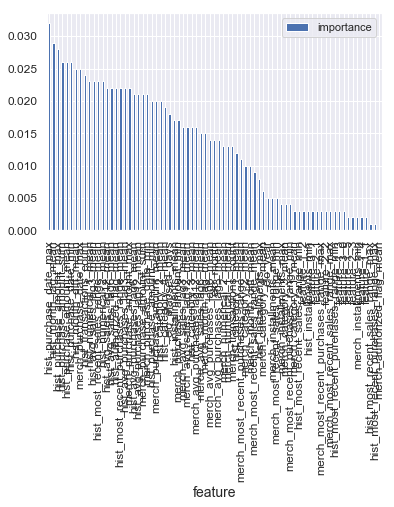

In [7]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier();

refclasscol = train[model_feats].columns

# fit random forest classifier on the training set
rfc_model.fit(train[model_feats], target);

# extract important features
score = np.round(rfc_model.feature_importances_, 3)
importances = pd.DataFrame({'feature':refclasscol, 'importance':score})
importances = importances.sort_values('importance', ascending=False).set_index('feature')

# plot importances
importances.plot.bar();

In [8]:
# Stratified sampling based on the service feature categorical values
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=50)
for trn_index, val_index in split.split(train, train['outliers_ind']):
    strat_train_set = train.loc[trn_index]
    strat_val_set = train.loc[val_index]

# Print number of instances for train and test dataset
print("Stratified Sampling: ", len(strat_train_set), "train +", len(strat_val_set), "validation")

trn_target_y = strat_train_set['outliers_ind']
val_target_y = strat_val_set['outliers_ind']
strat_train_set = strat_train_set[model_feats]
strat_val_set = strat_val_set[model_feats]

Stratified Sampling:  151437 train + 50480 validation


In [9]:
def calc_sens_spec(conf_matrix):
    TP = conf_matrix[1][1]; TN = conf_matrix[0][0]; FP = conf_matrix[0][1]; FN = conf_matrix[1][0];
    sensitivity = TP / float(TP + FN); specificity = TN / float(TN + FP);
    return sensitivity, specificity

In [15]:
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

# selecting features using threshold
feat_imp_threshold = importances.loc[(importances['importance'] < np.max(importances['importance'])) &
                                     (importances['importance'] <= 0.010)]

# fit model using each importance as a threshold
thresholds = np.sort(np.unique(feat_imp_threshold.importance))
thresholds = [0.006]
for thresh in thresholds:
    thresholds = np.sort(np.unique(feat_imp_threshold.importance))
    selection = SelectFromModel(rfc_model, threshold=thresh, prefit=True)
    select_train = selection.transform(strat_train_set)
    
    # training model
    selection_model = RandomForestClassifier()
    selection_model.fit(select_train, trn_target_y)
    scores = cross_val_score(selection_model, select_train, trn_target_y, cv=10)

    # prediction through model for training dataset
    pred_trn_out = selection_model.predict(select_train)
    pred_trn_out_prob = selection_model.predict_proba(select_train)[:, 1]
    
    # evaluating training model
    accuracy = metrics.accuracy_score(trn_target_y, pred_trn_out)
    confusion = metrics.confusion_matrix(trn_target_y, pred_trn_out)
    sensitivity, specifivity = calc_sens_spec(confusion)

    print("Thresh=%.3f, n=%d, Train Accuracy: %.2f%%, Cross Val Mean Score=%.2f%%, Sensitivity=%.2f%%, Specifivity=%.2f%%" % 
            (thresh, select_train.shape[1], accuracy*100.0, scores.mean()*100.0, sensitivity*100.0, specifivity*100.0))

    # prediction through model for training dataset
    select_val = selection.transform(strat_val_set)
    pred_val_out = selection_model.predict(select_val)
    pred_val_out_prob = selection_model.predict_proba(select_val)[:, 1]
    
    # evaluating testing model
    accuracy = metrics.accuracy_score(val_target_y, pred_val_out)
    confusion = metrics.confusion_matrix(val_target_y, pred_val_out)
    sensitivity, specifivity = calc_sens_spec(confusion)

    print("Thresh=%.3f, n=%d, Val Accuracy: %.2f%%, Cross Val Mean Score=%.2f%%, Sensitivity=%.2f%%, Specifivity=%.2f%%" % 
            (thresh, select_val.shape[1], accuracy*100.0, scores.mean()*100.0, sensitivity*100.0, specifivity*100.0))
    print("\n")

Thresh=0.006, n=48, Train Accuracy: 98.51%, Cross Val Mean Score=90.43%, Sensitivity=83.98%, Specifivity=100.00%
Thresh=0.006, n=48, Val Accuracy: 90.48%, Cross Val Mean Score=90.43%, Sensitivity=2.09%, Specifivity=99.55%




In [12]:
# Check calssification parameters performance based on cutoff values on class probabilities predicted
cutoff_range = [0.05, 0.06, 0.09, 0.095, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

for cut_off in cutoff_range:
    new_pred_trn_class = np.where(pred_trn_out_prob > cut_off, 1, 0)

    new_confusion = metrics.confusion_matrix(trn_target_y, new_pred_trn_class)
    new_sensitivity, new_specificity = calc_sens_spec(new_confusion)
    new_trn_accuracy = metrics.accuracy_score(trn_target_y, new_pred_trn_class)

    print("Train Dataset - Cutoff : %.2f, Train Accuracy: %.2f%%, Train Sensitivity=%.2f%%, Train Specificity=%.2f%%" % 
         (cut_off, new_trn_accuracy*100.0, new_sensitivity*100.0, new_specificity*100.0))
    
    new_pred_val_class = np.where(pred_val_out_prob > cut_off, 1, 0)

    new_confusion = metrics.confusion_matrix(val_target_y, new_pred_val_class)
    new_sensitivity, new_specificity = calc_sens_spec(new_confusion)
    new_val_accuracy = metrics.accuracy_score(val_target_y, new_pred_val_class)

    print("Val Dataset - Cutoff : %.3f, Val Accuracy: %.2f%%, Val Sensitivity=%.2f%%, Val Specificity=%.2f%%" % 
         (cut_off, new_val_accuracy*100.0, new_sensitivity*100.0, new_specificity*100.0))
    
    print('\n')

Train Dataset - Cutoff : 0.05, Train Accuracy: 74.75%, Train Sensitivity=100.00%, Train Specificity=72.16%
Val Dataset - Cutoff : 0.050, Val Accuracy: 49.76%, Val Sensitivity=76.48%, Val Specificity=47.02%


Train Dataset - Cutoff : 0.06, Train Accuracy: 74.75%, Train Sensitivity=100.00%, Train Specificity=72.16%
Val Dataset - Cutoff : 0.060, Val Accuracy: 49.76%, Val Sensitivity=76.48%, Val Specificity=47.02%


Train Dataset - Cutoff : 0.09, Train Accuracy: 74.75%, Train Sensitivity=100.00%, Train Specificity=72.16%
Val Dataset - Cutoff : 0.090, Val Accuracy: 49.76%, Val Sensitivity=76.48%, Val Specificity=47.02%


Train Dataset - Cutoff : 0.10, Train Accuracy: 74.75%, Train Sensitivity=100.00%, Train Specificity=72.16%
Val Dataset - Cutoff : 0.095, Val Accuracy: 49.76%, Val Sensitivity=76.48%, Val Specificity=47.02%


Train Dataset - Cutoff : 0.10, Train Accuracy: 93.92%, Train Sensitivity=99.99%, Train Specificity=93.30%
Val Dataset - Cutoff : 0.100, Val Accuracy: 71.95%, Val Sensit

In [13]:
selection_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters Tuning for Random Forest
rf_param_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [100, 50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 }
forest = RandomForestClassifier()
rf_cross_val = StratifiedKFold(n_splits=5)

rf_grid_search = GridSearchCV(forest,
                              scoring='accuracy',
                              param_grid=rf_param_grid,
                              cv=rf_cross_val,
                              verbose=1
                              )

rf_grid_search.fit(select_train, trn_target_y)
rf_model = rf_grid_search
rf_parameters = rf_grid_search.best_params_

rf_model = RandomForestClassifier(**rf_parameters)

rf_model.fit(select_train, trn_target_y)
scores = cross_val_score(rf_model, select_train, trn_target_y, cv=10)

print('Cross-validation of : {0}'.format(rf_model.__class__))
print('After Hyperparameters tuning CV score = {0}'.format(scores))
print('Best score: {}'.format(rf_grid_search.best_score_))
print('Best parameters: {}'.format(rf_grid_search.best_params_))

In [ ]:
pred_outliers = reduce_mem_usage(pd.read_csv("train_lgb_v5_out.csv"))
print('Train dataset dimension: {} rows, {} columns'.format(pred_outliers.shape[0], pred_outliers.shape[1]))

pred_wo_outliers = reduce_mem_usage(pd.read_csv("train_lgb_v5_no_out.csv"))
print('Train dataset dimension: {} rows, {} columns'.format(pred_wo_outliers.shape[0], pred_wo_outliers.shape[1]))

train_df_org = reduce_mem_usage(pd.read_csv("datasets/train.csv", parse_dates=["first_active_month"]))
print('Train dataset dimension: {} rows, {} columns'.format(train_df_org.shape[0], train_df_org.shape[1]))

test_pred_outliers = reduce_mem_usage(pd.read_csv("test_lgb_v5_out.csv"))
print('Train dataset dimension: {} rows, {} columns'.format(test_pred_outliers.shape[0], test_pred_outliers.shape[1]))

test_pred_wo_outliers = reduce_mem_usage(pd.read_csv("test_lgb_v5_no_out.csv"))
print('Train dataset dimension: {} rows, {} columns'.format(test_pred_wo_outliers.shape[0], test_pred_wo_outliers.shape[1]))

In [ ]:
train_predictions = pd.merge(train_df_org, pred_outliers, on='card_id', how='left')
train_predictions = pd.merge(train_predictions, pred_wo_outliers, on='card_id', how='left')
print('Train dataset dimension: {} rows, {} columns'.format(train_predictions.shape[0], train_predictions.shape[1]))
train_predictions.head()

In [ ]:
train_predictions.describe()

In [ ]:
train_pred_out = train_predictions[train_predictions['outliers_ind'] == 1]
train_pred_wo_out = train_predictions[train_predictions['outliers_ind'] == 0]

train_pred_out.describe()

In [ ]:
train_pred_wo_out.describe()

In [ ]:
test_predictions = pd.merge(test_pred_outliers, test_pred_wo_outliers, on='card_id', how='left')
test_predictions.describe()

In [ ]:
train_predictions['pred_wo_out'] = train_predictions['pred_wo_out'].fillna(-33.21875)
train_predictions['comb_pred'] = (train_predictions['pred_wo_out'] +  train_predictions['pred_out'])  / 2.0
train_pred_out = train_predictions[train_predictions['outliers_ind'] == 1]
train_pred_wo_out = train_predictions[train_predictions['outliers_ind'] == 0]

train_predictions.describe()

In [ ]:
train_pred_out.describe()

In [ ]:
train_pred_wo_out.describe()

In [ ]:
target = train_predictions['target']
new_pred_target = train_predictions['comb_pred']
print('New Training RMSE with Outliers: ', np.sqrt(mean_squared_error(new_pred_target, target)))

target = train_pred_wo_out['target']
new_pred_target = train_pred_wo_out['comb_pred']
print('New Training RMSE w/o Outliers: ', np.sqrt(mean_squared_error(new_pred_target, target)))

In [ ]:
train_predictions.head()

In [ ]:
# Get the X and Y
train = train_df_proc.copy()
test = test_df_proc.copy()

train = pd.merge(train, train_predictions[['card_id', 'comb_pred']], on='card_id', how='left')
target = train['comb_pred']

cols_not_to_consider = ['card_id', 'first_active_month', 'target', 'outliers_ind', 'comb_pred']
model_feats = [c for c in train_df_proc.columns if c not in cols_not_to_consider]

train.head()

In [ ]:
%%time

param = {'num_leaves': 31, 'min_data_in_leaf': 32, 'objective':'regression', 'max_depth': -1, 'learning_rate': 0.005,
         "boosting": "gbdt", "feature_fraction": 0.9, "bagging_freq": 1, "bagging_fraction": 0.9,
         "bagging_seed": 11, "metric": 'rmse', "lambda_l1": 0.1, "verbosity": -1, "nthread": 4}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=201)
oof_lgb_comb = np.zeros(len(train))
pred_lgb_comb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['feature_3_0'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][model_feats], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][model_feats], label=target.iloc[val_idx])

    num_round = 10000
    lgb_model = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    oof_lgb_comb[val_idx] = lgb_model.predict(train.iloc[val_idx][model_feats], num_iteration=lgb_model.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = model_feats
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    pred_lgb_comb += lgb_model.predict(test[model_feats], num_iteration=lgb_model.best_iteration) / folds.n_splits

In [ ]:
print('Training RMSE with Outliers & New Predictions: ', np.sqrt(mean_squared_error(oof_lgb_comb, target)))

sample_submission = pd.read_csv('datasets/sample_submission.csv')
sample_submission['target'] = pred_lgb_comb
sample_submission.to_csv('test_lgb_v5_comb.csv', index=False)

train_pred_out = pd.DataFrame({"card_id":train_df_proc["card_id"].values, 
                               "target":train_df_proc["target"].values, 
                               "outliers":train_df_proc["outliers_ind"].values})
train_pred_out["pred_comb"] = oof_lgb_comb
train_pred_out.to_csv('train_lgb_v5_comb.csv', index=False)